# Titanic Survival Prediction

#### Data = Titanic Dataset from kaggle.com

**Task - Using the given data predict whether a passenger will survive the incident or not.**

**Evaluation Metric = Accuracy**

**Attribute Information:**

* **survival:**	Survival	0 = No, 1 = Yes
* **pclass:**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
* **sex:**	Sex	
* **Age:**	Age in years	
* **sibsp:**	Number of siblings / spouses aboard the Titanic	
* **parch:**	Number of parents / children aboard the Titanic	
* **ticket:**	Ticket number	
* **fare:**	Passenger fare	
* **cabin:**	Cabin number	
* **embarked:**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

### Importing necessary Libraries

In [301]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

### Importing Data into Dataframes.

In [395]:
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA and Data Preparation

In [396]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [397]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [398]:
print("Number of people who died: ",train['Survived'].value_counts()[0])       # Imbalanced Data
print("Number of people who survived: ",train['Survived'].value_counts()[1])

Number of people who died:  549
Number of people who survived:  342


### Checking for null values in the data.

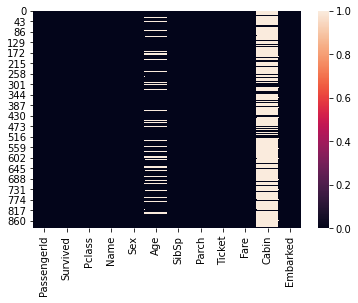

In [399]:
sns.heatmap(train.isnull()==True)

**Dropping the cabin column as it has very less data and dropping the passenger id column as it does not provide any useful information to us.**

In [400]:
train.drop(labels= ['Cabin','PassengerId','Name'], axis = 1,inplace = True)

### Univariate Analysis on Ticket column

In [401]:
train['Ticket'].nunique() #there are 681 unique values of tickets available but there are 891 passengers.

681

**How can the ticket number of 2 passengers be same?**

Ans. Passengers travelling together have same ticket number.

**From the given example we can see that these 4 passengers were from the same family and were travelling together. Therefore they have same ticket number and also the same fare.**

**Mrs. Nils was the mother along with her 3 children.**

In [402]:
train[train['Ticket']== "349909"]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
7,0,3,male,2.0,3,1,349909,21.075,S
24,0,3,female,8.0,3,1,349909,21.075,S
374,0,3,female,3.0,3,1,349909,21.075,S
567,0,3,female,29.0,0,4,349909,21.075,S


**Having the same ticket gives us same information as having a family member on board.**

In [403]:
# Summing up the no. of siblings, spouse, parents ,children to get the total no. of family members onboard.
train['Family_onboard'] =  train['SibSp']+train['Parch']  

In [404]:
train.drop(labels=['Ticket'],axis = 1,inplace = True)   #Dropping the Ticket  column

In [405]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_onboard
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,1
2,1,3,female,26.0,0,0,7.9250,S,0
3,1,1,female,35.0,1,0,53.1000,S,1
4,0,3,male,35.0,0,0,8.0500,S,0


### Univariate Analysis on Age column

In [406]:
print('No. of null values in the Age column:',train[train['Age'].isnull()==True].shape[0]
      ,"i.e",train[train['Age'].isnull()==True].shape[0]/891 *100,"%")

No. of null values in the Age column: 177 i.e 19.865319865319865 %


In [407]:
grp = train.groupby(['Sex','Pclass'])

In [408]:
grp['Age'].median()    # Grouping the data by sex and passenger class and finding median age of the class.

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

In [409]:
train['Age'].fillna(value = 0,inplace = True)

In [410]:
#Filling the appropriate age where there were null values in the age column with median values of that sex and class.
start = datetime.now()
for i in range(0,891):
    if(train['Sex'][i]=='male' and train['Pclass'][i]==1):
        if(train['Age'][i]==0):
            train['Age'][i] = 40.0
            continue
    elif(train['Sex'][i]=='male' and train['Pclass'][i]==2):
        if(train['Age'][i]==0):
            train['Age'][i] = 30.0
            continue
    elif(train['Sex'][i]=='male' and train['Pclass'][i]==3):
        if(train['Age'][i]==0):
            train['Age'][i] = 25.0
            continue
    elif(train['Sex'][i]=='female' and train['Pclass'][i]==1):
        if(train['Age'][i]==0):
            train['Age'][i] = 35.0
            continue
    elif(train['Sex'][i]=='female' and train['Pclass'][i]==2):
        if(train['Age'][i]==0):
            train['Age'][i] = 28.0 
            continue
    elif(train['Sex'][i]=='female' and train['Pclass'][i]==3):
        if(train['Age'][i]==0):
            train['Age'][i] = 21.0
            continue
print("All the null values of the age column have been handled successfully!")
print("Time taken to run this cell: ",datetime.now()-start)

All the null values of the age column have been handled successfully!
Time taken to run this cell:  0:03:53.306488


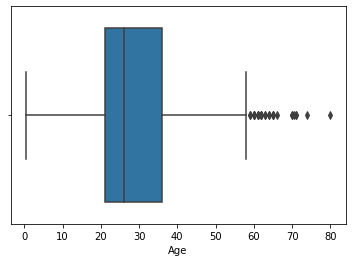

In [411]:
sns.boxplot(train['Age'])

In [412]:
print("No. of Children onboard:",train[train['Age']<=18]['Age'].count())
print("No. of Adults onboard:",train[train['Age']>18]['Age'].count())

No. of Children onboard: 139
No. of Adults onboard: 752


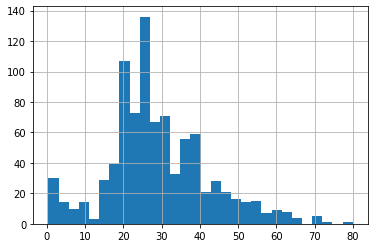

In [413]:
train['Age'].hist(bins = 30)

**Changing age to a categorical column:**

In [414]:
data = [train]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 7
    
    dataset['Age'] = dataset['Age'].astype(str)
    dataset.loc[ dataset['Age'] == '0', 'Age'] = "Children"
    dataset.loc[ dataset['Age'] == '1', 'Age'] = "Teens"
    dataset.loc[ dataset['Age'] == '2', 'Age'] = "Youngsters"
    dataset.loc[ dataset['Age'] == '3', 'Age'] = "Young Adults"
    dataset.loc[ dataset['Age'] == '4', 'Age'] = "Adults"
    dataset.loc[ dataset['Age'] == '5', 'Age'] = "Middle Age"
    dataset.loc[ dataset['Age'] == '6', 'Age'] = "Senior"
    dataset.loc[ dataset['Age'] == '7', 'Age'] = "Retired"

In [415]:
train['Age'].value_counts()

Young Adults    200
Senior          141
Adults          137
Youngsters      134
Middle Age      133
Teens            71
Children         68
Retired           7
Name: Age, dtype: int64

In [416]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_onboard
0,0,3,male,Youngsters,1,0,7.2500,S,1
1,1,1,female,Middle Age,1,0,71.2833,C,1
2,1,3,female,Young Adults,0,0,7.9250,S,0
3,1,1,female,Middle Age,1,0,53.1000,S,1
4,0,3,male,Middle Age,0,0,8.0500,S,0


### Univariate Analysis on Passenger Class column

In [417]:
train['Pclass'].value_counts()
# Maximum number of passengers belonged to the 3rd class and were probably crew members and staff

3    491
1    216
2    184
Name: Pclass, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B5DCB8B320>,
      dtype=object)

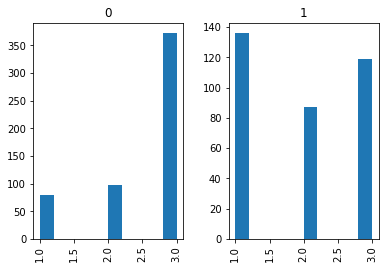

In [418]:
train['Pclass'].hist(by=train['Survived'])

**From this we can see that most of the people who died were of 3rd class.**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B5DCC85CC0>,
      dtype=object)

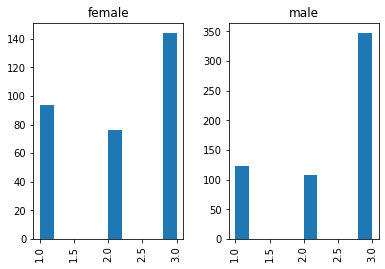

In [419]:
train['Pclass'].hist(by=train['Sex'])

**Changing Pclass column into categoical column with strings.**

In [420]:
data = [train]

for dataset in data:
    dataset['Pclass'] = dataset['Pclass'].astype(str)
    dataset.loc[ dataset['Pclass'] == '1', 'Pclass'] = "Class1"
    dataset.loc[ dataset['Pclass'] == '2', 'Pclass'] = "Class2"
    dataset.loc[ dataset['Pclass'] == '3', 'Pclass'] = "Class3"

In [421]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_onboard
0,0,Class3,male,Youngsters,1,0,7.2500,S,1
1,1,Class1,female,Middle Age,1,0,71.2833,C,1
2,1,Class3,female,Young Adults,0,0,7.9250,S,0
3,1,Class1,female,Middle Age,1,0,53.1000,S,1
4,0,Class3,male,Middle Age,0,0,8.0500,S,0


### Univariate analysis on Embarked Column.

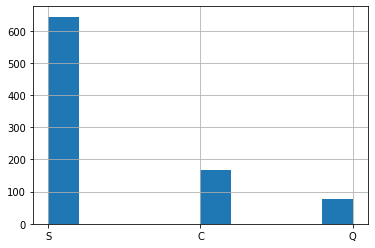

In [422]:
train['Embarked'].hist()  # Most of the passengers boarded the titanic at Southampton

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B5DCDA8390>,
      dtype=object)

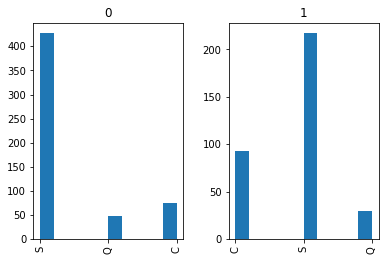

In [423]:
train['Embarked'].hist(by=train['Survived'])

In [424]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [425]:
train['Embarked'].fillna(train['Embarked'].mode(),inplace = True)

In [426]:
# train['Embarked'] = train['Embarked'].map({"S":0,'C':1,'Q':2})
# train['Embarked_C'] = train['Embarked'].map({"S":0,'C':1,'Q':0})
# train['Embarked_Q'] = train['Embarked'].map({"S":0,'C':0,'Q':1})
# train.drop(labels = ['Embarked'],axis=1,inplace = True)

## Univariate Analysis on Fare Column.

In [427]:
train['Fare'].describe() # Maximum fare on the titanic is 512.32 Euros.

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

**On futher reasearch on the internet we found that Miss Annie was employed as a personal maid to the wealthy widow Charlotte
Drake Cardeza. Mr. Thomas was Mrs Cardeza's son and Gustave Lesurer was Mr Thomas's manservant. They boarded the titanic 
together at Cherbourg on 10 April 1912 with picely fare of 512 euros.**

In [428]:
train[train['Fare']==512.329200]    # All 3 of these are 1st class passengers and hence paid the highest Fare.

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family_onboard
258,1,Class1,female,Middle Age,0,0,512.3292,C,0
679,1,Class1,male,Middle Age,0,1,512.3292,C,1
737,1,Class1,male,Middle Age,0,0,512.3292,C,0


In [429]:
grp = train.groupby(['Pclass'])
grp['Fare'].mean() 

Pclass
Class1    84.154687
Class2    20.662183
Class3    13.675550
Name: Fare, dtype: float64

**Changing Fare column to categorical from continuous.**

In [430]:
data = [train]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset['Fare'] = dataset['Fare'].astype(str)
    dataset.loc[ dataset['Fare'] == '0', 'Fare'] = "Extremely Low"
    dataset.loc[ dataset['Fare'] == '1', 'Fare'] = "Very Low"
    dataset.loc[ dataset['Fare'] == '2', 'Fare'] = "Low"
    dataset.loc[ dataset['Fare'] == '3', 'Fare'] = "High"
    dataset.loc[ dataset['Fare'] == '4', 'Fare'] = "Very High"
    dataset.loc[ dataset['Fare'] == '5', 'Fare'] = "Extremely High"

In [431]:
train['Family_onboard'].unique()

array([ 1,  0,  4,  2,  6,  5,  3,  7, 10], dtype=int64)

In [433]:
train['is_alone'] = train['Family_onboard'].map({1:0,  0:1,  4:0,  2:0,  6:0,  5:0,  3:0,  7:0, 10:0})

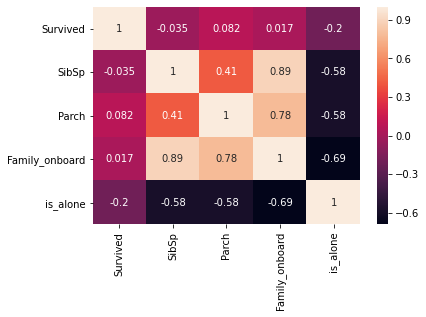

In [434]:
sns.heatmap(train.corr(),annot = True)  # Checking for multicollinearity in the data.

**As Sibsp, Parch and Family onboard and is_alone are highly correlated therefore keeping only is_alone column and drop others.**

In [435]:
train.drop(labels=['SibSp','Parch','Family_onboard'],axis =1,inplace = True)
train['is_alone']=train['is_alone'].map({0:"no",1:'yes'})

### One Hot Encoding the features

In [437]:
col_list = list(train.select_dtypes(include=['object']).columns)
for i in col_list:
    train = pd.concat([train,pd.get_dummies(train[i], prefix=i)],axis=1)
    train.drop(i, axis = 1, inplace=True)

In [438]:
train.head()

,Survived,Pclass_Class1,Pclass_Class2,Pclass_Class3,Sex_female,Sex_male,Age_Adults,Age_Children,Age_Middle Age,Age_Retired,...,Fare_Extremely Low,Fare_High,Fare_Low,Fare_Very High,Fare_Very Low,Embarked_C,Embarked_Q,Embarked_S,is_alone_no,is_alone_yes
0,0,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
1,1,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
2,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
3,1,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
4,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,1


In [439]:
train.columns

Index(['Survived', 'Pclass_Class1', 'Pclass_Class2', 'Pclass_Class3',
       'Sex_female', 'Sex_male', 'Age_Adults', 'Age_Children',
       'Age_Middle Age', 'Age_Retired', 'Age_Senior', 'Age_Teens',
       'Age_Young Adults', 'Age_Youngsters', 'Fare_Extremely High',
       'Fare_Extremely Low', 'Fare_High', 'Fare_Low', 'Fare_Very High',
       'Fare_Very Low', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'is_alone_no', 'is_alone_yes'],
      dtype='object')

### Splitting the data into Train and Test set.

In [440]:
X = train[['Pclass_Class1', 'Pclass_Class2', 'Pclass_Class3',\
       'Sex_female', 'Sex_male', 'Age_Adults', 'Age_Children',\
       'Age_Middle Age', 'Age_Retired', 'Age_Senior', 'Age_Teens',\
       'Age_Young Adults', 'Age_Youngsters', 'Fare_Extremely High',\
        'Fare_Extremely Low', 'Fare_High', 'Fare_Low', 'Fare_Very High',\
        'Fare_Very Low', 'Embarked_C', 'Embarked_Q', 'Embarked_S','is_alone_no', 'is_alone_yes']]
y = train['Survived']

In [441]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [442]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(623, 24) (623,)
(268, 24) (268,)


In [443]:
y_train.value_counts()   # we will have to give weights to make the classes balanced.

0    392
1    231
Name: Survived, dtype: int64

In [444]:
y_test.value_counts()

0    157
1    111
Name: Survived, dtype: int64

In [446]:
# This function trains the specified classifier with default parameters and prints train and test accuracy.

def basic_train_eval(classifier,xtrain,xtest,ytrain,ytest):
    model = classifier
    model.fit(xtrain,ytrain)
    train_pred = model.predict(xtrain)
    test_pred = model.predict(xtest)
    print("Training and predicting on default parameters: \n")
    print("Accuracy on train data: ",accuracy_score(ytrain,train_pred))
    print("Accuracy on test data: ",accuracy_score(ytest,test_pred))
    print("\n")
    print(classification_report(ytest,test_pred))
    print(confusion_matrix(ytest,test_pred))

In [447]:
basic_train_eval(LogisticRegression(class_weight='balanced'),X_train,X_test,y_train,y_test)

Training and predicting on default parameters: 

Accuracy on train data:  0.7913322632423756
Accuracy on test data:  0.7761194029850746


              precision    recall  f1-score   support

           0       0.83      0.77      0.80       157
           1       0.71      0.78      0.74       111

    accuracy                           0.78       268
   macro avg       0.77      0.78      0.77       268
weighted avg       0.78      0.78      0.78       268

[[121  36]
 [ 24  87]]


In [448]:
basic_train_eval(SVC(),X_train,X_test,y_train,y_test)  # OVERFITTING

Training and predicting on default parameters: 

Accuracy on train data:  0.7849117174959872
Accuracy on test data:  0.7910447761194029


              precision    recall  f1-score   support

           0       0.80      0.85      0.83       157
           1       0.77      0.70      0.74       111

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268

[[134  23]
 [ 33  78]]


In [449]:
basic_train_eval(GaussianNB(),X_train,X_test,y_train,y_test)

Training and predicting on default parameters: 

Accuracy on train data:  0.7688603531300161
Accuracy on test data:  0.7388059701492538


              precision    recall  f1-score   support

           0       0.77      0.78      0.78       157
           1       0.69      0.68      0.68       111

    accuracy                           0.74       268
   macro avg       0.73      0.73      0.73       268
weighted avg       0.74      0.74      0.74       268

[[123  34]
 [ 36  75]]


In [450]:
basic_train_eval(KNeighborsClassifier(),X_train,X_test,y_train,y_test) # OVERFITTING

Training and predicting on default parameters: 

Accuracy on train data:  0.8459069020866774
Accuracy on test data:  0.75


              precision    recall  f1-score   support

           0       0.78      0.80      0.79       157
           1       0.70      0.68      0.69       111

    accuracy                           0.75       268
   macro avg       0.74      0.74      0.74       268
weighted avg       0.75      0.75      0.75       268

[[125  32]
 [ 35  76]]


In [451]:
basic_train_eval(RandomForestClassifier(),X_train,X_test,y_train,y_test) # OVERFITTING

Training and predicting on default parameters: 

Accuracy on train data:  0.9020866773675762
Accuracy on test data:  0.7873134328358209


              precision    recall  f1-score   support

           0       0.79      0.86      0.83       157
           1       0.78      0.68      0.73       111

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.78       268
weighted avg       0.79      0.79      0.78       268

[[135  22]
 [ 35  76]]


In [452]:
basic_train_eval(xgb.XGBClassifier(),X_train,X_test,y_train,y_test) # OVERFITTING

Training and predicting on default parameters: 

Accuracy on train data:  0.8443017656500803
Accuracy on test data:  0.8059701492537313


              precision    recall  f1-score   support

           0       0.79      0.91      0.85       157
           1       0.84      0.66      0.74       111

    accuracy                           0.81       268
   macro avg       0.81      0.78      0.79       268
weighted avg       0.81      0.81      0.80       268

[[143  14]
 [ 38  73]]


## Hyperparameter Tuning 

In [453]:
# This function takes the classifier and parameter grid as parameters and performs Grid Search and 5 fold Cross Validation
# and gives us the best score.

def grid_tuning(classifier,param_grid):
    start = datetime.now()
    grid = GridSearchCV(estimator = classifier,param_grid=param_grid,cv=5)
    grid.fit(X_train,y_train)
    print("Best Parameters: ",grid.best_params_,"\n")
    train_pred = grid.predict(X_train)
    test_pred = grid.predict(X_test)
    print("Accuracy on train data: ",accuracy_score(y_train,train_pred))
    print("Accuracy on test data: ",accuracy_score(y_test,test_pred),"\n")
    print(classification_report(y_test,test_pred))
    print(confusion_matrix(y_test,test_pred),"\n")
    print("Time taken to run this cell: ",datetime.now()-start)

In [454]:
lr_param = {'penalty':['l1','l2'],'C':[0.0001,0.001,0.01,0.1,1,10],'solver':['liblinear'],'class_weight':['balanced']}
grid_tuning(LogisticRegression(),param_grid=lr_param)

Best Parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'} 

Accuracy on train data:  0.7865168539325843
Accuracy on test data:  0.7910447761194029 

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       157
           1       0.77      0.70      0.74       111

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268

[[134  23]
 [ 33  78]] 

Time taken to run this cell:  0:00:00.501146


In [455]:
svc_param={"C":[0.001,0.01,0.1,1,10],'class_weight':['balanced']}
grid_tuning(SVC(),param_grid=svc_param)   

Best Parameters:  {'C': 10, 'class_weight': 'balanced'} 

Accuracy on train data:  0.8378812199036918
Accuracy on test data:  0.7910447761194029 

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       157
           1       0.75      0.75      0.75       111

    accuracy                           0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268

[[129  28]
 [ 28  83]] 

Time taken to run this cell:  0:00:00.674863


In [456]:
rfc_param= {'n_estimators':[5,10,20,40,70,100,150,200],"criterion":['gini','entropy'],'class_weight':['balanced'],\
            'max_depth':[3,4,5,6,7,8]}
grid_tuning(RandomForestClassifier(),param_grid=rfc_param)   

Best Parameters:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'n_estimators': 20} 

Accuracy on train data:  0.8539325842696629
Accuracy on test data:  0.7798507462686567 

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       157
           1       0.76      0.68      0.72       111

    accuracy                           0.78       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268

[[133  24]
 [ 35  76]] 

Time taken to run this cell:  0:01:19.626957


In [457]:
xgb_param = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }
grid_tuning(xgb.XGBClassifier(),param_grid=xgb_param)   

Best Parameters:  {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5} 

Accuracy on train data:  0.841091492776886
Accuracy on test data:  0.8022388059701493 

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       157
           1       0.83      0.66      0.73       111

    accuracy                           0.80       268
   macro avg       0.81      0.78      0.79       268
weighted avg       0.81      0.80      0.80       268

[[142  15]
 [ 38  73]] 

Time taken to run this cell:  0:26:36.753658


### Importing Test Data and Generating Submission File

In [474]:
test= pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [475]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [476]:
test['Fare'].fillna(value=20,inplace = True)

In [477]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [478]:
passId = test['PassengerId']

In [479]:
# Performing all the preprocessing steps on the test data to get it in the right format for prediction.
start = datetime.now()
test.drop(labels=['PassengerId','Name','Ticket','Cabin'],axis = 1,inplace=True)
test['Age'].fillna(value = 0,inplace = True)
for i in range(0,test.shape[0]):
    if(test['Sex'][i]=='male' and test['Pclass'][i]==1):
        if(test['Age'][i]==0):
            test['Age'][i] = 40.0
            continue
    elif(test['Sex'][i]=='male' and test['Pclass'][i]==2):
        if(test['Age'][i]==0):
            test['Age'][i] = 30.0
            continue
    elif(test['Sex'][i]=='male' and test['Pclass'][i]==3):
        if(test['Age'][i]==0):
            test['Age'][i] = 25.0
            continue
    elif(test['Sex'][i]=='female' and test['Pclass'][i]==1):
        if(test['Age'][i]==0):
            test['Age'][i] = 35.0
            continue
    elif(test['Sex'][i]=='female' and test['Pclass'][i]==2):
        if(test['Age'][i]==0):
            test['Age'][i] = 28.0 
            continue
    elif(test['Sex'][i]=='female' and test['Pclass'][i]==3):
        if(test['Age'][i]==0):
            test['Age'][i] = 21.0
            continue     
print("Null values of Age column handled successfully!!\n")            
data = [test]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 7
    
    dataset['Age'] = dataset['Age'].astype(str)
    dataset.loc[ dataset['Age'] == '0', 'Age'] = "Children"
    dataset.loc[ dataset['Age'] == '1', 'Age'] = "Teens"
    dataset.loc[ dataset['Age'] == '2', 'Age'] = "Youngsters"
    dataset.loc[ dataset['Age'] == '3', 'Age'] = "Young Adults"
    dataset.loc[ dataset['Age'] == '4', 'Age'] = "Adults"
    dataset.loc[ dataset['Age'] == '5', 'Age'] = "Middle Age"
    dataset.loc[ dataset['Age'] == '6', 'Age'] = "Senior"
    dataset.loc[ dataset['Age'] == '7', 'Age'] = "Retired"   
print('Converted Age column to categorical successfully!!\n')
for dataset in data:
    dataset['Pclass'] = dataset['Pclass'].astype(str)
    dataset.loc[ dataset['Pclass'] == '1', 'Pclass'] = "Class1"
    dataset.loc[ dataset['Pclass'] == '2', 'Pclass'] = "Class2"
    dataset.loc[ dataset['Pclass'] == '3', 'Pclass'] = "Class3" 
print('Converted Pclass column to categorical successfully!!\n')
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset['Fare'] = dataset['Fare'].astype(str)
    dataset.loc[ dataset['Fare'] == '0', 'Fare'] = "Extremely Low"
    dataset.loc[ dataset['Fare'] == '1', 'Fare'] = "Very Low"
    dataset.loc[ dataset['Fare'] == '2', 'Fare'] = "Low"
    dataset.loc[ dataset['Fare'] == '3', 'Fare'] = "High"
    dataset.loc[ dataset['Fare'] == '4', 'Fare'] = "Very High"
    dataset.loc[ dataset['Fare'] == '5', 'Fare'] = "Extremely High"  
print('Converted Fare column to categorical successfully!!\n')    
test['Family_onboard'] =  test['SibSp']+test['Parch']    
test['is_alone'] = test['Family_onboard'].map({1:0,  0:1,  4:0,  2:0,  6:0,  5:0,  3:0,  7:0, 10:0})
test.drop(labels=['SibSp','Parch','Family_onboard'],axis =1,inplace = True)
test['is_alone']=test['is_alone'].map({0:"no",1:'yes'})
col_list = list(test.select_dtypes(include=['object']).columns)
for i in col_list:
    test = pd.concat([test,pd.get_dummies(test[i], prefix=i)],axis=1)
    test.drop(i, axis = 1, inplace=True)     
print('Preprocessing Completed Successfully!\n')
print('Time Taken in preprocessing: ',datetime.now()-start)

Null values of Age column handled successfully!!

Converted Age column to categorical successfully!!

Converted Pclass column to categorical successfully!!

Converted Fare column to categorical successfully!!

Preprocessing Completed Successfully!

Time Taken in preprocessing:  0:01:59.020855


In [483]:
# Training the XGBoost model on best obtained parameters.
xgbc = xgb.XGBClassifier(colsample_bytree= 0.7, gamma= 0.1, learning_rate=0.05, max_depth= 4, min_child_weight= 5)
xgbc.fit(X,y)
xgbc_train_pred = xgbc.predict(X)
# xgbc_test_pred = xgbc.predict(X_test)
print("Training Accuracy: ",accuracy_score(y,xgbc_train_pred))
# print("Test Accuracy: ",accuracy_score(y_test,xgbc_test_pred))

Training Accuracy:  0.8282828282828283


In [484]:
result = xgbc.predict(test)

In [485]:
# sub1 = pd.DataFrame(passId,columns = ['PassengerId'])
# sub1['Survived'] = result
# sub1.to_csv("Sub1.csv",index = False)

**Accuracy = 78.468%  Rank: 6536**

In [486]:
gxgb = GridSearchCV(xgb.XGBClassifier(),param_grid=xgb_param,cv = 5)
gxgb.fit(X,y)

In [488]:
result_new = gxgb.predict(test)

In [489]:
# sub2 = pd.DataFrame(passId,columns = ['PassengerId'])
# sub2['Survived'] = result_new
# sub2.to_csv("Sub1.csv",index = False)

**Accuracy = 78.947%  Rank: 4865**